In [203]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn
# !pip install catboost

# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#cat boost추가
# import catboost
# from catboost import CatBoostClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# oversampling, undersampling
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

# EDA

## 변수 설명
  - **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
  - **annual_inc** : 연 소득 (annual income)
  - **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
  - **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
  - **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
  - **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
  - **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
  - **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
  - **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
  - **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
  - **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
  - **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
  - **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
  - **delinq_amnt** : 체납 금액 (delinquency amount)
  - **tax_liens** : 세금 저당권의 수 (Number of tax liens)
  - **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
  - **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
  - **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
  - **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
  - **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
  - **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
  - **funded_amnt** : 대출액 (Funded amount)
  - **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
  - **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
  - **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
  - **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
  - **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
  - **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
  - **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
  - **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
  - **total_rec_int** : 이자 상환액 (Interest received to date)
  - **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
  - **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
  - **depvar** : 고객의 부도 여부 (dependent variable)

In [205]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/220126/data/train.csv')
df.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1


In [206]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/220126//data/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/220126//data/test.csv')

df_test = df_test.drop(columns=['ID'])


## 컬럼 합쳐주기

In [207]:
def concat_column(dataframe, feature_name, start_idx, end_idx):
    dataframe[feature_name] = 0

    for i, column in enumerate(dataframe.loc[:,f'{feature_name}{start_idx}':f'{feature_name}{end_idx}'].columns,1):
        for j, data in enumerate(dataframe[column]):
            if data == 1:
                dataframe[feature_name][j] = i

    dataframe = dataframe.drop(dataframe.loc[:,f'{feature_name}{start_idx}':f'{feature_name}{end_idx}'].columns, axis=1)
    return dataframe

In [208]:
df = concat_column(df, 'emp_length', 1, 12)

In [209]:
df = concat_column(df, 'home_ownership', 1, 6)

In [210]:
df = concat_column(df, 'verification_status', 1, 3)

In [211]:
df = concat_column(df, 'purpose', 1, 14)

In [212]:
df = concat_column(df, 'initial_list_status', 1, 2)

In [213]:
df = concat_column(df, 'mths_since_last_delinq', 1, 11)

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  int64  
 7   total_acc                   100000 non-null  int64  
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  int64  
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

In [215]:
df.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.130833,7.436061e+04,18.514508,0.343700,0.668880,0.235720,16090.202820,24.675910,0.018810,0.005800,250.588120,1.305281e+05,0.009630,19.288330,0.063820,13735.317750,13729.341073,2.448885e+00,0.855920,11.620700,434.077648,0.537233,0.253327,0.253259,2491.282802,692.630550,696.630660,0.325690,5.084010,4.022680,1.966200,3.660050,1.565570,3.774040
std,0.044773,7.467409e+04,8.413049,0.905007,0.952044,0.661468,21569.939271,11.883834,0.150321,0.083585,2042.770881,1.503326e+05,0.110079,893.304366,0.468027,8464.825314,8461.694483,1.489496e+01,0.351173,5.458774,265.921746,0.239373,18.053290,18.051746,2706.262200,29.668017,29.668584,0.468634,3.569059,1.915234,0.780169,2.362892,0.495684,3.410721
min,0.053200,5.360000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1000.000000,800.000000,-2.000000e-09,0.000000,1.000000,23.360000,0.000000,0.000000,0.000000,0.000000,660.000000,664.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.097500,4.500000e+04,12.200000,0.000000,0.000000,0.000000,6009.000000,16.000000,0.000000,0.000000,0.000000,2.698900e+04,0.000000,0.000000,0.000000,7200.000000,7200.000000,0.000000e+00,1.000000,8.000000,240.292500,0.361000,0.000000,0.000000,857.292500,670.000000,674.000000,0.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000
50%,0.127400,6.200000e+04,18.060000,0.000000,0.000000,0.000000,11030.500000,23.000000,0.000000,0.000000,0.000000,6.802350e+04,0.000000,0.000000,0.000000,12000.000000,12000.000000,0.000000e+00,1.000000,11.000000,366.370000,0.541000,0.000000,0.000000,1615.160000,685.000000,689.000000,0.000000,4.000000,5.000000,2.000000,3.000000,2.000000,2.000000
75%,0.158000,9.000000e+04,24.530000,0.000000,1.000000,0.000000,19540.000000,31.000000,0.000000,0.000000,0.000000,1.943098e+05,0.000000,0.000000,0.000000,19200.000000,19200.000000,0.000000e+00,1.000000,14.000000,575.860000,0.720000,0.000000,0.000000,3039.115000,705.000000,709.000000,1.000000,8.000000,6.000000,3.000000,3.000000,2.000000,7.000000
max,0.309900,8.300000e+06,49.930000,20.000000,6.000000,63.000000,971736.000000,176.000000,5.000000,6.000000,197765.000000,3.164353e+06,7.000000,94521.000000,63.000000,40000.000000,40000.000000,8.741700e+02,1.000000,82.000000,1584.900000,8.923000,2330.970000,2330.970000,28005.960000,845.000000,850.000000,1.000000,12.000000,6.000000,3.000000,14.000000,2.000000,11.000000


In [216]:
# 결측치 확인
pd.DataFrame(df.isnull().sum()).rename(columns={0:'Non-Null Count'}).T

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq
Non-Null Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Test데이터 컬럼 합쳐주기

In [217]:
df_test = concat_column(df_test, 'emp_length', 1, 12)

In [218]:
df_test = concat_column(df_test, 'home_ownership', 1, 6)

In [219]:
df_test = concat_column(df_test, 'verification_status', 1, 3)

In [220]:
df_test = concat_column(df_test, 'purpose', 1, 14)

In [221]:
df_test = concat_column(df_test, 'initial_list_status', 1, 2)

In [222]:
df_test = concat_column(df_test, 'mths_since_last_delinq', 1, 11)

## 다중공선성 제거

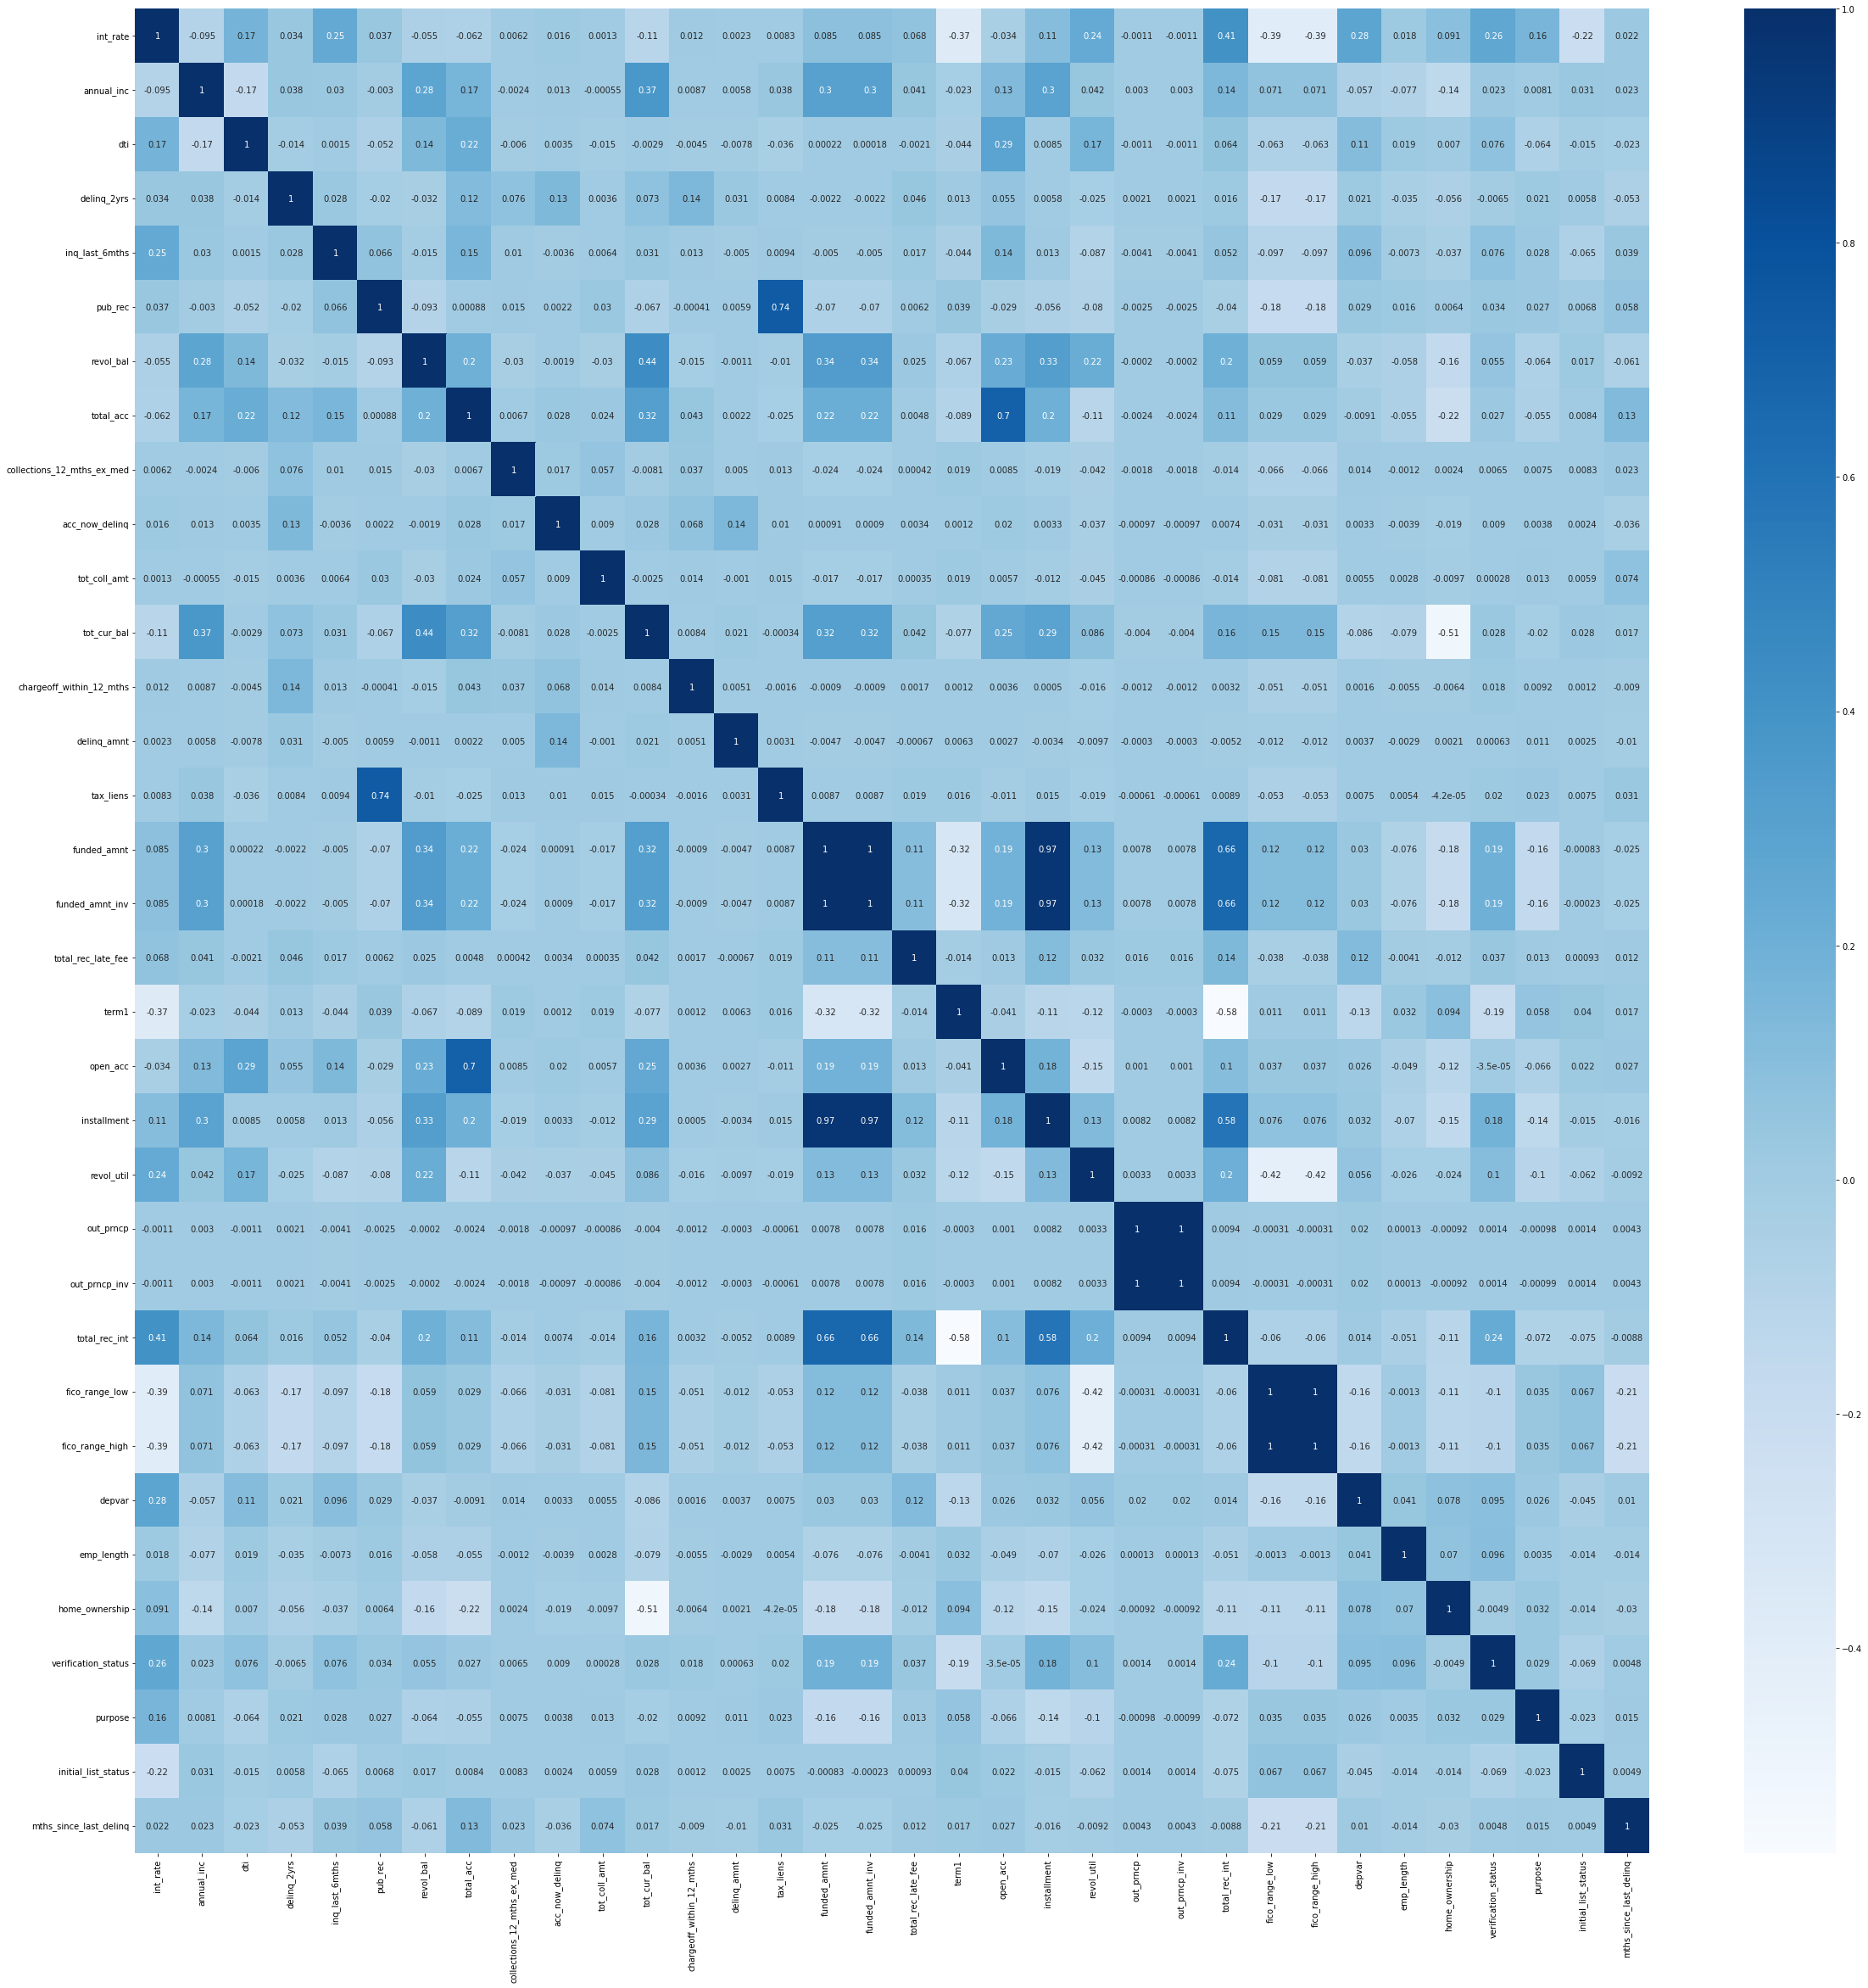

In [223]:
plt.figure(figsize = (40,40))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show()

In [224]:
plt.figure(figsize = (10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [225]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns
vif

,VIF Factor,features
0,3.162523e+01,int_rate
1,2.599180e+00,annual_inc
2,7.594651e+00,dti
3,1.307289e+00,delinq_2yrs
4,1.719833e+00,inq_last_6mths
5,2.786214e+00,pub_rec
6,2.280120e+00,revol_bal
7,1.205961e+01,total_acc
8,1.033660e+00,collections_12_mths_ex_med
9,1.051278e+00,acc_now_delinq


In [226]:
vif[vif["VIF Factor"] > 10].sort_values('VIF Factor',ascending=False)

,VIF Factor,features
26,4.288446e+07,fico_range_high
25,4.278937e+07,fico_range_low
22,2.881544e+06,out_prncp
23,2.881544e+06,out_prncp_inv
15,2.995235e+05,funded_amnt
16,2.990609e+05,funded_amnt_inv
20,3.302920e+02,installment
18,5.128236e+01,term1
0,3.162523e+01,int_rate
19,1.229736e+01,open_acc


In [227]:
for column in vif[vif["VIF Factor"] > 10]['features']:
    print(column, df[column].corr(df['depvar']))

int_rate 0.27794396446258884
total_acc -0.009060165120316578
funded_amnt 0.03029829494081517
funded_amnt_inv 0.03027849810973255
term1 -0.13018530497821956
open_acc 0.026434878843903883
installment 0.03183214230790652
out_prncp 0.02019088678181373
out_prncp_inv 0.020187201605045
fico_range_low -0.15584008634806276
fico_range_high -0.15583968589230732
initial_list_status -0.04451497756271098


In [228]:
# 라벨(depvar) 비율 확인
print('y=1 ratio :', df.depvar.sum()/len(df))

y=1 ratio : 0.32569


In [229]:
# rfe로 feature selection train에 과적합 되는 것을 방지
# df = df.drop(['fico_range_high','out_prncp_inv','funded_amnt'],axis=1)
df = df.drop(['fico_range_high','out_prncp','acc_now_delinq','funded_amnt','installment'],axis=1)

In [230]:
df_test = df_test.drop(['fico_range_high','out_prncp','acc_now_delinq','funded_amnt','installment'],axis=1)

## 이상치 확인(제거는 아래)

In [231]:
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data <= upper_bound)&(data >= lower_bound)) #조건에 해당하는 인덱스를 반환

int_rate


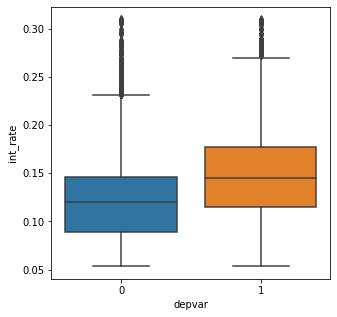

annual_inc


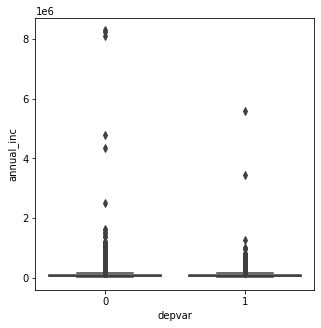

dti


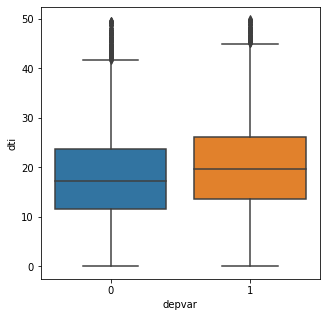

delinq_2yrs


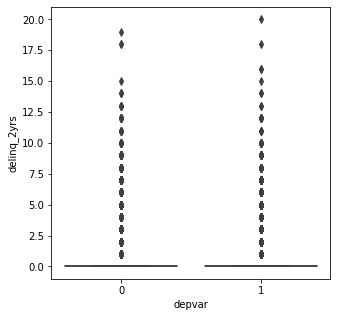

inq_last_6mths


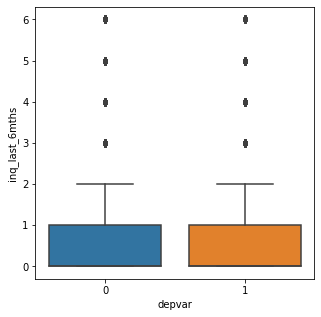

pub_rec


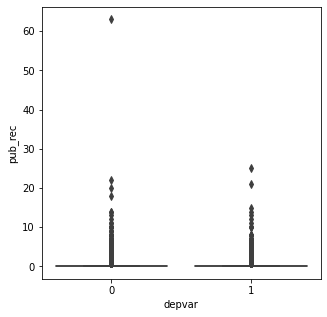

revol_bal


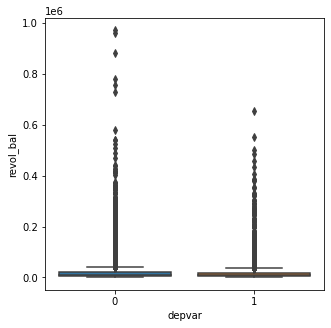

total_acc


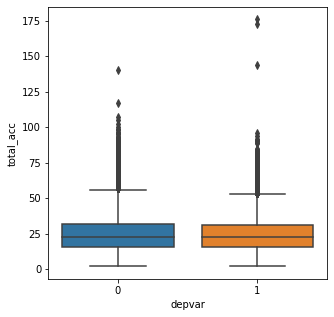

collections_12_mths_ex_med


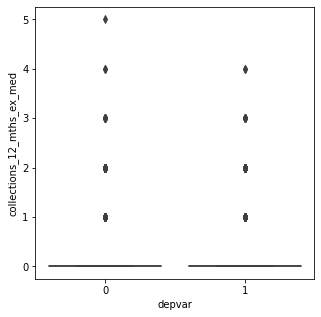

tot_coll_amt


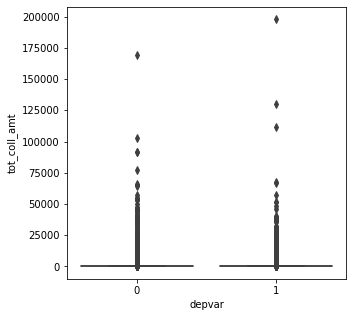

tot_cur_bal


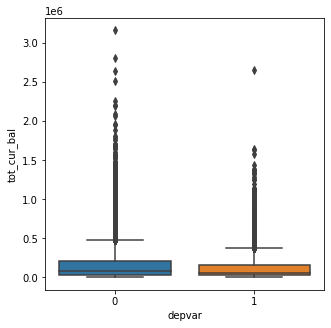

chargeoff_within_12_mths


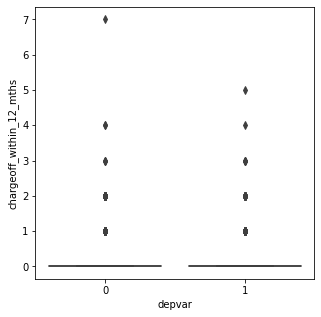

delinq_amnt


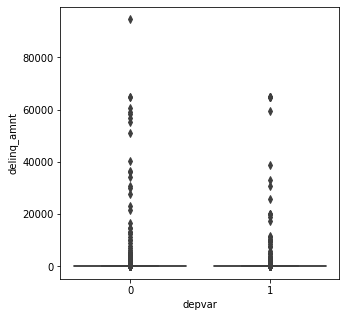

tax_liens


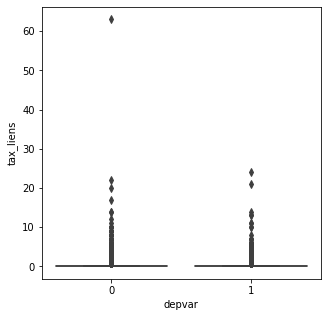

funded_amnt_inv


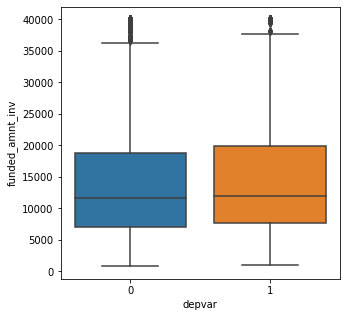

total_rec_late_fee


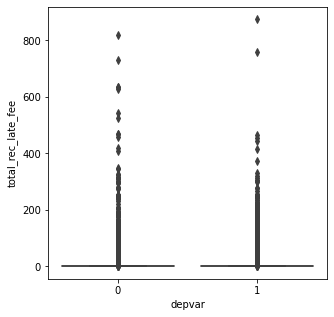

term1


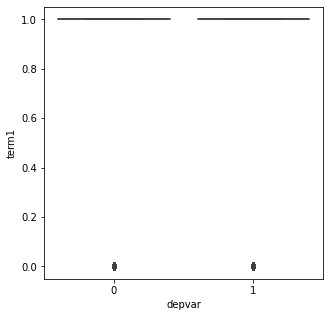

open_acc


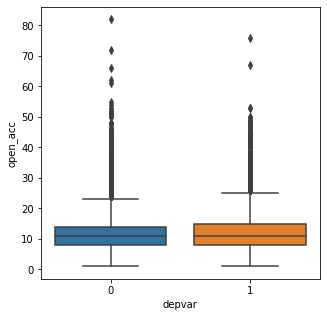

revol_util


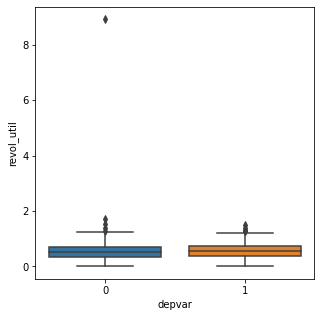

out_prncp_inv


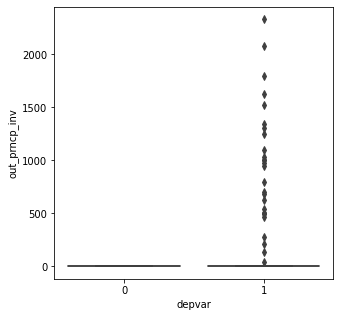

total_rec_int


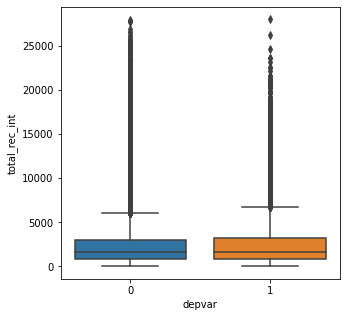

fico_range_low


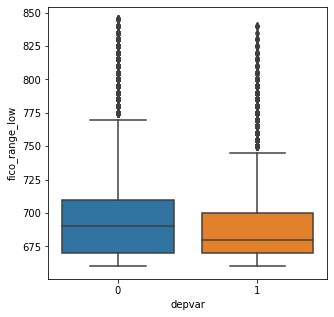

depvar


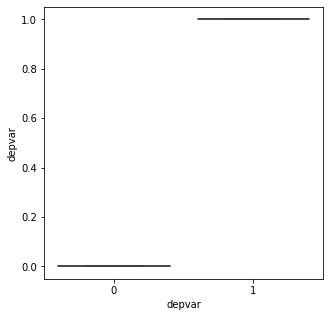

emp_length


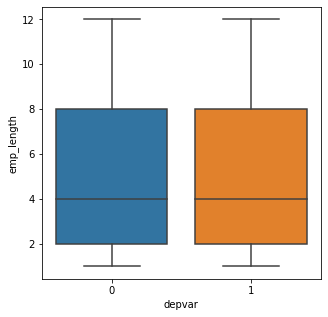

home_ownership


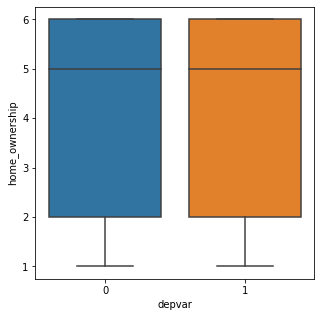

verification_status


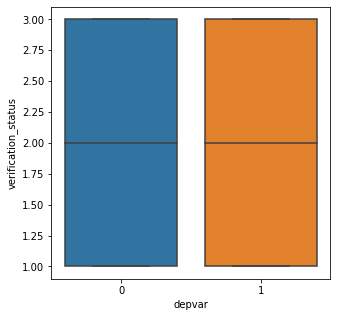

purpose


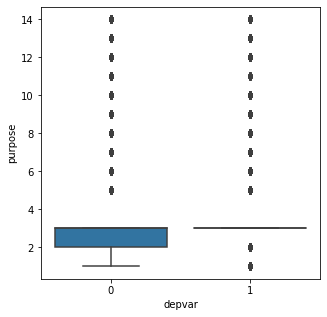

initial_list_status


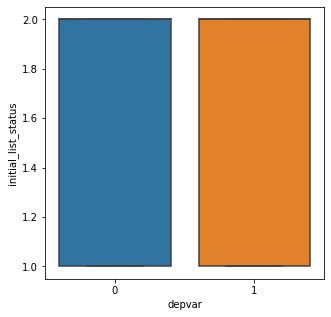

mths_since_last_delinq


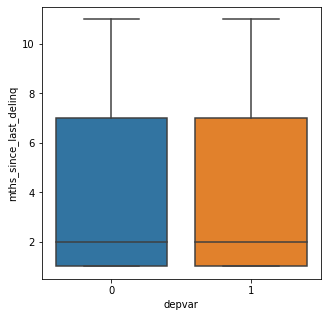

In [232]:
for column in df.columns:
    print(column)
    plt.figure(figsize=(5,5))
    sns.boxplot(x="depvar", y=column, data=df)
    plt.show()

In [233]:
X = df.drop('depvar', axis=1)
y = df['depvar']

## 결정계수 확인

In [234]:
# import statsmodels.api as sm
# from numpy.linalg import svd
# X = sm.add_constant(X)
# model = sm.Logit(y,X)
# results = model.fit()

In [235]:
# print( results.summary() )
# Pseudo R-squ.: 0.1251, 제거한 feature: ['fico_range_high','out_prncp_inv']
# Pseudo R-squ.: , 제거한 feature: ['fico_range_high','out_prncp_inv','funded_amnt']

## RFECV(Feature selection)

In [236]:
# from sklearn.feature_selection import RFECV
# rfe = RFECV(estimator=DecisionTreeClassifier(),cv=5)
# rfe = rfe.fit(X, y.values.ravel())
# print(rfe.support_)
# for tf, column in zip(rfe.support_,X.columns):
#     print(f'{column} : {tf}')
# print(rfe.ranking_)

## Train Valid Split

In [237]:
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [238]:
# # 이상치 제거
# idx_list = outliers_iqr(X_train['int_rate'])[0]
# X_train = X_train.iloc[idx_list]
# y_train = y_train.iloc[idx_list]

In [239]:
print(len(X_train), len(y_train))

80000 80000


# valid로 테스트

# Single Model(XGBoost)
## XGBClassifier의 하이퍼 파라미터 설명
- **LINK** : https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
- **max_depth=3** : 디시전 트리의 최대 깊이
- **learning_rate=0.1** : 0과 1 사이의 값을 가지는 부스팅에 대한 학습률(eta). 매 부스팅 단계 이후 새로이 추가된 가중치는 이 파라미터로 조정된다. 이 값이 낮을수록 보수적이며, 수렴에 필요한 더 많은 디시전 트리가 필요하다.
- **n_estimators=100** : 라운드의 횟수 또는 부스팅된 디시전 트리의 개수
- **silent=True** : 부스팅의 수행 동안 메시지를 출력할지에 대한 여부
- **objective="reg:linear"** : 모델이 학습할 작업의 분류, 미리 정의된 작업은 문자열로 지정이 가능하지만, 그렇지 않은 경우 콜러블callable을 만들어서 지정할 수도 있다.
- **booster="gbtree"** : 'gbtree', 'gblinear', 'dart'일 수 있다. 'dart'는 드롭아웃(dropout)이라는 특성을 추가한다(과적합 방지를 위해 무작위로 디시전 트리를 선택해 제거(드롭)한다). 'gblinear'는 정규화된 선형 모델을 만든다(디시전 트리가 아니라 라소 회귀와 유사하다).
- **nthread=None** : 더 이상 사용되지 않는다.
- **n_jobs** : 사용할 스레드의 개수
- **gamma=0** : 노드 분할에 필요한 최소 손실 감소
- **min_child_weight=1** : 자식 노드 생성에 필요한 헤시안(hessian) 합의 최솟값
- **max_delta_step=0** : 보다 보수적으로 갱신을 수행하도록 만드는 값. 불균형 범주의 데이터셋에 대해서는 1부터 10까지의 값으로 설정한다.
- **subsample=1** : 부스팅에 사용할 샘플의 비율
- **colsample_bytree=1** : 부스팅에 사용할 특징 열의 비율
- **colsample_bylevel=1** : 각 디시전 트리의 수준별 사용할 특징 열의 비율
- **colsample_bynode=1** : 각 디시전 트리의 노드별 사용할 특징 열의 비율
- **reg_alpha=0** : L1 정규화(가중치의 평균). 이 값이 클수록 보수적이게 된다.
- **reg_lambda=1** : L2 정규화(가중치의 제곱근). 이 값이 클수록 보수적이게 된다.
- **base_score=.5** : 초기 편향치(bias)
- **seed=None** : 더 이상 사용되지 않는다.
- **random_state=0** : 난수 생성 시드
- **missing=None** : 누락된 데이터가 해석될 값. None은 np.nan을 의미한다.
- **importance_type='gain'** : 특징 중요도의 유형. 'gain', 'weight', 'cover', 'total_gain', 'total_cover'로 설정될 수 있다.

In [240]:
# best parameter를 사용하여 prediction 수행
xgb_clf = xgboost.XGBClassifier(max_depth = 10,
                                n_estimators = 300
                                  )

In [241]:
#CV기반 스태킹 모델별 학습 부분
def get_stacking_data(model, X_train, y_train, X_test, n_folds=5, n_repeats=1, random_state=36851234, resample_type='SMOTETomek'):
    acc_list = []
    pre_list = []
    re_list = []
    auc_list = []
    f1_list = []

    cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=random_state)

    # (X_shape크기,1)의 크기를 갖는다.
    new_X_train = np.zeros((X_train.shape[0], 1))

    new_X_test = np.zeros((X_test.shape[0], n_folds  * n_repeats))

    for cnt, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        print("TRAIN:", train_index, "TEST:", valid_index)
        X_train_, X_valid_ = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_, y_valid_ = y_train.iloc[train_index], y_train.iloc[valid_index]

        # # 데이터 oversampling, undersampling
        # if resample_type == 'SMOTETomek':
        #     X_train_, y_train_ = SMOTETomek().fit_resample(X_train_, y_train_)
        # elif resample_type == 'SMOTE':
        #     X_train_, y_train_ = SMOTETomek().fit_resample(X_train_, y_train_)
        # elif resample_type == 'TomekLinks':
        #     X_train_, y_train_ = TomekLinks().fit_resample(X_train_, y_train_)

        # 학습
        model.fit(X_train_,y_train_)

        # 검증 예측 결과 데이터로 새로운 트레인 데이터 생성
        y_pred_ = model.predict(X_valid_)
        new_X_train[valid_index, :] = y_pred_.reshape(-1, 1)

        #fold별 성능 list에 추가
        acc_list.append(accuracy_score(y_pred_, y_valid_))
        pre_list.append(precision_score(y_pred_, y_valid_))
        re_list.append(recall_score(y_pred_, y_valid_))
        auc_list.append(roc_auc_score(y_pred_, y_valid_))
        f1_list.append(f1_score(y_pred_, y_valid_))

        # 테스트 예측 결과 데이터로 새로운 테스트 데이터 생성
        new_X_test[:, cnt] = model.predict_proba(X_test)[:,1]

    new_X_test_mean = np.mean(new_X_test, axis=1).reshape(-1, 1)

    # 모델별 성능 평가
    print('\n정확도: {:.4f}'.format(np.mean(acc_list)))
    print('정밀도: {:.4f}'.format(np.mean(pre_list)))
    print('재현율: {:.4f}'.format(np.mean(re_list)))
    print('AUC: {:.4f}'.format(np.mean(auc_list)))
    print('F1: {:.4f}'.format(np.mean(f1_list)))

    return new_X_train, new_X_test_mean

##LGBM

In [242]:
# lgbm cv stacking 데이터 생성
lgbm_clf = LGBMClassifier(max_depth = 15,
                          n_estimators = 400
                          )

In [243]:
y_pred_train, y_pred_valid = get_stacking_data(lgbm_clf, X_train, y_train, X_valid, n_folds=5, n_repeats=1, random_state=36851234, resample_type='SMOTETomek')

# 정확도: 0.7517
# 정밀도: 0.5469
# 재현율: 0.6402
# AUC: 0.7175
# F1: 0.5899

TRAIN: [    0     1     2 ... 79996 79998 79999] TEST: [    3    13    14 ... 79984 79994 79997]
TRAIN: [    0     1     3 ... 79996 79997 79999] TEST: [    2     7    18 ... 79990 79992 79998]
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [    4     9    11 ... 79976 79989 79996]
TRAIN: [    1     2     3 ... 79997 79998 79999] TEST: [    0    12    25 ... 79965 79969 79988]
TRAIN: [    0     2     3 ... 79996 79997 79998] TEST: [    1     5     6 ... 79993 79995 79999]

정확도: 0.7526
정밀도: 0.4908
재현율: 0.6604
AUC: 0.7212
F1: 0.5631


##Final classification

0.29672550701656597


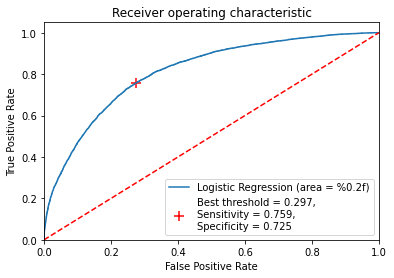

In [244]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(best_thresh)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
sens, spec = tpr[ix], 1-fpr[ix]
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.3f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [354]:
#threshold 조정
y_predict_valid = (y_pred_valid > best_thresh).astype(int)

In [355]:
sum(y_predict_valid)/len(y_predict_valid)

array([0.43445])


정확도: 0.7359
정밀도: 0.5749
재현율: 0.7587
AUC: 0.7417
F1: 0.6541


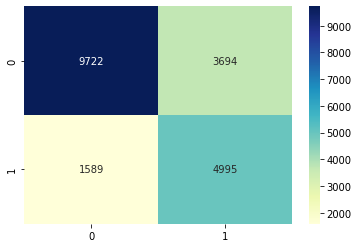

In [356]:
get_clf_eval(y_valid, y_predict_valid)
# 제거한 feature: ['fico_range_high','out_prncp','acc_now_delinq','funded_amnt']
# 정확도: 0.7359
# 정밀도: 0.5749
# 재현율: 0.7587
# AUC: 0.7417
# F1: 0.6541

# TEST에 적용

# Single Model(XGBoost)
## XGBClassifier의 하이퍼 파라미터 설명
- **LINK** : https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
- **max_depth=3** : 디시전 트리의 최대 깊이
- **learning_rate=0.1** : 0과 1 사이의 값을 가지는 부스팅에 대한 학습률(eta). 매 부스팅 단계 이후 새로이 추가된 가중치는 이 파라미터로 조정된다. 이 값이 낮을수록 보수적이며, 수렴에 필요한 더 많은 디시전 트리가 필요하다.
- **n_estimators=100** : 라운드의 횟수 또는 부스팅된 디시전 트리의 개수
- **silent=True** : 부스팅의 수행 동안 메시지를 출력할지에 대한 여부
- **objective="reg:linear"** : 모델이 학습할 작업의 분류, 미리 정의된 작업은 문자열로 지정이 가능하지만, 그렇지 않은 경우 콜러블callable을 만들어서 지정할 수도 있다.
- **booster="gbtree"** : 'gbtree', 'gblinear', 'dart'일 수 있다. 'dart'는 드롭아웃(dropout)이라는 특성을 추가한다(과적합 방지를 위해 무작위로 디시전 트리를 선택해 제거(드롭)한다). 'gblinear'는 정규화된 선형 모델을 만든다(디시전 트리가 아니라 라소 회귀와 유사하다).
- **nthread=None** : 더 이상 사용되지 않는다.
- **n_jobs** : 사용할 스레드의 개수
- **gamma=0** : 노드 분할에 필요한 최소 손실 감소
- **min_child_weight=1** : 자식 노드 생성에 필요한 헤시안(hessian) 합의 최솟값
- **max_delta_step=0** : 보다 보수적으로 갱신을 수행하도록 만드는 값. 불균형 범주의 데이터셋에 대해서는 1부터 10까지의 값으로 설정한다.
- **subsample=1** : 부스팅에 사용할 샘플의 비율
- **colsample_bytree=1** : 부스팅에 사용할 특징 열의 비율
- **colsample_bylevel=1** : 각 디시전 트리의 수준별 사용할 특징 열의 비율
- **colsample_bynode=1** : 각 디시전 트리의 노드별 사용할 특징 열의 비율
- **reg_alpha=0** : L1 정규화(가중치의 평균). 이 값이 클수록 보수적이게 된다.
- **reg_lambda=1** : L2 정규화(가중치의 제곱근). 이 값이 클수록 보수적이게 된다.
- **base_score=.5** : 초기 편향치(bias)
- **seed=None** : 더 이상 사용되지 않는다.
- **random_state=0** : 난수 생성 시드
- **missing=None** : 누락된 데이터가 해석될 값. None은 np.nan을 의미한다.
- **importance_type='gain'** : 특징 중요도의 유형. 'gain', 'weight', 'cover', 'total_gain', 'total_cover'로 설정될 수 있다.

In [248]:
len(df.columns)

29

In [249]:
len(df_test.columns)

28

In [250]:
# X = X.drop(['const'],axis=1)

##LGBM

In [251]:
# lgbm cv stacking 데이터 생성
lgbm_clf = LGBMClassifier(max_depth = 15,
                          n_estimators = 400
                          )

In [252]:
lgbm_tomek_train, lgbm_tomek_test = get_stacking_data(lgbm_clf, X, y, df_test, n_folds=5, n_repeats=1, random_state=36851234, resample_type='SMOTETomek')
# 정확도: 0.7519
# 정밀도: 0.5399
# 재현율: 0.6416
# AUC: 0.7176
# F1: 0.5863

TRAIN: [    0     1     3 ... 99995 99997 99998] TEST: [    2     6     7 ... 99977 99996 99999]
TRAIN: [    2     3     4 ... 99996 99997 99999] TEST: [    0     1     8 ... 99991 99995 99998]
TRAIN: [    0     1     2 ... 99997 99998 99999] TEST: [    5     9    10 ... 99969 99972 99974]
TRAIN: [    0     1     2 ... 99996 99998 99999] TEST: [   12    13    14 ... 99990 99994 99997]
TRAIN: [    0     1     2 ... 99997 99998 99999] TEST: [    3     4    11 ... 99981 99992 99993]

정확도: 0.7554
정밀도: 0.4985
재현율: 0.6664
AUC: 0.7252
F1: 0.5703


##Final classification

In [253]:
new_X_train = lgbm_tomek_train
y_predict_test= lgbm_tomek_test

# Submission

### 결과



In [349]:
submit['answer'] = (y_predict_test > 0.345).astype(int)

print(best_thresh)

sum(submit['answer'])/len(submit['answer'])
# best answer: 0.3760051373687737

0.29672550701656597


0.38898816171543443

In [350]:
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/220126//data/prediction.csv', index=False)

In [351]:
best_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/220126//data/best_answer.csv')

In [352]:
idx = []
for i, (ans1, ans2) in enumerate(zip(submit["answer"],best_df["answer"])):
    if ans1 != ans2:
        idx.append(i)

In [353]:
len(idx)

1921

### 이번에 한 일

1. TOMEK를 TOMKESMOTE로 변경하여 테스트해봄
2. CV stacking 모델로 성능 평가

### 다음으로 해볼 일


1. 트레인 predict 데이터와 label, valid predict 데이터와 label을 그래프로 나타내서 양상이 어떤지 확인해보기

2. Parameter 튜닝 특히 min_leaves에 대해 튜닝하는 것을 위주로 해야 성능이 잘 나온다고 함

4. 다중공선성 결정계수 낮아지지 않게 해보기

5. 이상치 제거

6. Ridge, Lasso regularization

## 현재 돌고 있는 모델

CV stacking 적용된 xgb, lgbm에 tomek, smotetomek feature 2개만 제거